In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import stored dataframe 'enrolled_gpas' from Feature_Engineering notebook
%store -r enrolled_gpas

# Logistic Regression

I wanted to see how the model is performing right now before I even gather the rest of the data and create the other features. Therefore, I went ahead and ran this preliminary LR. This is by no means my final model. My final attempts with LR with my completed features was done in R. 

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

# Features and response
X = enrolled_gpas[['age', 'id', 'totcr', 'status', 'stype', 'resd_desc',
                     'degcode', 'majr_desc1', 'gender', 'ethn_desc', 'cnty_desc1', 'styp', 
                     'resd', 'acd_std_desc', 'term_att_crhr', 'term_earn_crhr', 'term_gpa', 
                     'inst_gpa', 'inst_earned', 'inst_hrs_att', 'overall_gpa']]

y = enrolled_gpas['enrolled']

# One-hot encoding for categorical variables
encoder = OneHotEncoder(drop = 'first')  # 'drop' parameter is used to avoid multicollinearity
X_encoded = encoder.fit_transform(X)
#X_encoded = X_encoded.toarray()

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 101)

feature_names = X.columns

# Initialize and train the logistic regression model
logreg = LogisticRegression(max_iter = 10000)  # max_iter may need to be increased if the algorithm doesn't converge
logreg.fit(X_train, y_train)

# Predict probabilities
y_prob = logreg.predict_proba(X_test)[:, 1]

# Predictions
y_pred = logreg.predict(X_test)

# Model evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Enrolled       0.64      0.57      0.60      2348
Not Enrolled       0.73      0.79      0.76      3436

    accuracy                           0.70      5784
   macro avg       0.69      0.68      0.68      5784
weighted avg       0.69      0.70      0.69      5784



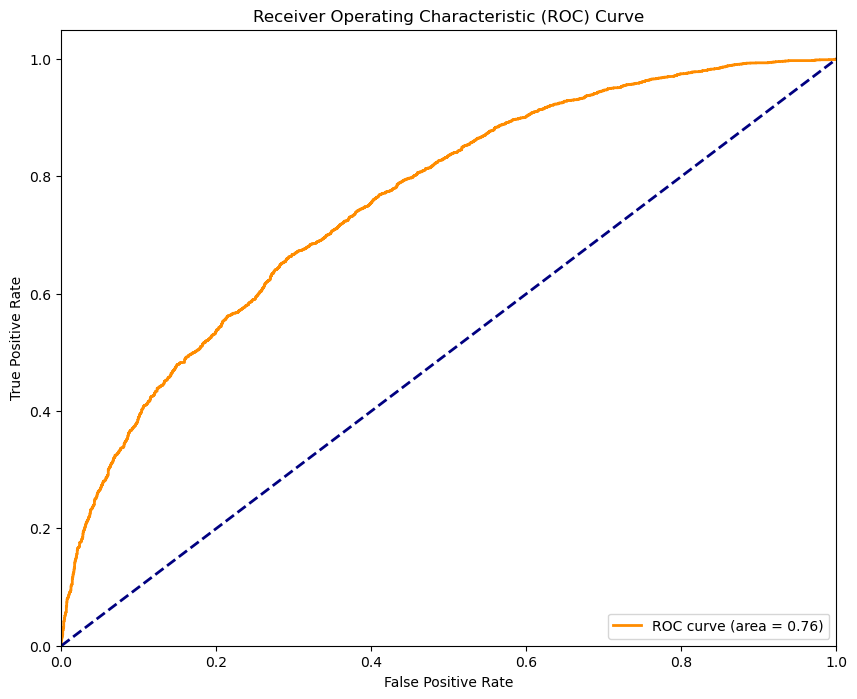

In [4]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_test_binary = (y_test == 'Enrolled').astype(int)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob, pos_label = 0)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = "lower right")
plt.show()

# XGBoost

In [7]:
%store -r enrolled_gpas_online_fafsa_hs

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [9]:
enrolled_gpas_xgb = enrolled_gpas_online_fafsa_hs[['enrolled', 'stype', 'gender', 'ethn_desc', 'resd', 'fully_online',
                                       'acd_std_desc', 'age', 'term_att_crhr', 'term_earn_crhr', 'term_gpa',
                                       'inst_gpa', 'inst_earned', 'no_pell', 'pell', 'subsidized', 'unsubsidized', 
                                       'summer_plus', 'kansas_promise', 'all_fafsa', 'hs_matriculation']]

# Encode 'enrolled' and 'not enrolled'
enrolled_gpas_xgb['enrolled'] = [1 if i == 'Enrolled' else 0 for i in enrolled_gpas_xgb['enrolled']]

# Check to make sure the 1 and 0 correspond to enrolled/not enrolled
#list(zip(list(enrolled_gpas_xgb['enrolled']), list(enrolled_gpas['enrolled'])))

# Filter out 'Z' from 'resd' (2 observations)
enrolled_gpas_xgb = enrolled_gpas_xgb[enrolled_gpas_xgb['resd'] != 'Z']

# Change NaN values in hs_matriculation to 'Not From HS'
enrolled_gpas_xgb['hs_matriculation'] = enrolled_gpas_xgb['hs_matriculation'].fillna('Not From HS')

# Filter out students over 60 and below the age of 10. This eliminates 123 over 60 and 3 below
# the age of 10. The three below the age of ten are obviously mistakes, two are below the age of 1
# and one is exactly two years old. The over 60 is almost entirely made up of current staff or 
# faculty, spouses, or previous faculty, staff, or spouses.
enrolled_gpas_xgb = enrolled_gpas_xgb[(enrolled_gpas_xgb['age'] <= 60) & (enrolled_gpas_xgb['age'] >= 10)]

enrolled_gpas_xgb = enrolled_gpas_xgb[enrolled_gpas_xgb['ethn_desc'] != 'DO NOT USE - Hispanic']

In [10]:
X = enrolled_gpas_xgb.drop('enrolled', axis = 1)
y = enrolled_gpas_xgb['enrolled'] # response variable

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [11]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Encode categorical variables
le = LabelEncoder()
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

# Create XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=101)

# Define hyperparameters for GridSearchCV
params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9]
}

# Perform grid search with cross-validation to select best hyperparameters
grid_search = GridSearchCV(xgb_clf, param_grid=params, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Fit XGBoost classifier with best hyperparameters
best_xgb_clf = grid_search.best_estimator_
best_xgb_clf.fit(X_train, y_train)

# Make predictions on test set
y_pred = best_xgb_clf.predict(X_test)

# Evaluate accuracy on test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.749131341209173


In [12]:
# After fitting GridSearchCV
best_hyperparams = grid_search.best_params_
print("Best hyperparameters: \n", best_hyperparams, '\n')

# Best score achieved during the grid search
best_score = grid_search.best_score_
print("Best accuracy score from GridSearchCV:\n", best_score)

Best hyperparameters: 
 {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9} 

Best accuracy score from GridSearchCV:
 0.754897454981789


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[2944  469]
 [ 975 1368]]


In [14]:
# accuracy calculated by hand
np.sum([cm[0,0],cm[1,1]]) / np.sum([cm])

0.749131341209173

In [15]:
#grid_search.best_estimator_
from sklearn.metrics import precision_score, recall_score, f1_score

TN = cm[0, 0]
FP = cm[0, 1]

# Calculate precision, recall, and F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
specificity = TN / (TN + FP)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print('Specificity:', specificity)

Precision: 0.7446924333151878
Recall: 0.5838668373879642
F1-Score: 0.6545454545454545
Specificity: 0.8625842367418693


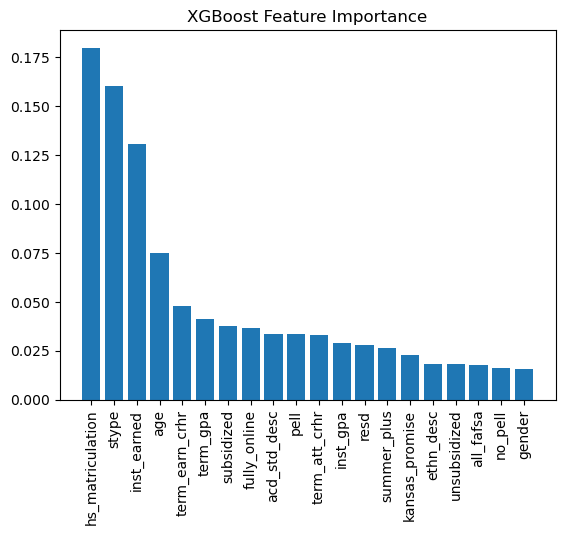

In [16]:
# Get feature importances
importances = best_xgb_clf.feature_importances_
features = X_train.columns

# Sort feature importance in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# create plot
plt.figure()

# create plot title
plt.title('XGBoost Feature Importance')

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation = 90)

# show plot
plt.show()

In [17]:
xgb_importance = pd.DataFrame.from_dict(dict(zip(names, list(importances[indices]))), orient = 'index')\
                   .reset_index()\
                   .rename(columns = {'index':'Variables',
                                       0:'Importance'})

xgb_importance['Cumsum_Importance'] = np.cumsum(xgb_importance['Importance'])

xgb_importance

,Variables,Importance,Cumsum_Importance
0,hs_matriculation,0.179744,0.179744
1,stype,0.160410,0.340154
2,inst_earned,0.130742,0.470896
3,age,0.074749,0.545646
4,term_earn_crhr,0.047749,0.593395
5,term_gpa,0.041031,0.634426
6,subsidized,0.037413,0.671839
7,fully_online,0.036663,0.708501
8,acd_std_desc,0.033457,0.741958
9,pell,0.033288,0.775246


In [18]:
imp = pd.DataFrame.from_dict(dict(zip(names, list(importances[indices]))), orient = 'index')\
        .reset_index()\
        .rename(columns = {'index':'Features',
                            0:'Importance'})

imp

,Features,Importance
0,hs_matriculation,0.179744
1,stype,0.160410
2,inst_earned,0.130742
3,age,0.074749
4,term_earn_crhr,0.047749
5,term_gpa,0.041031
6,subsidized,0.037413
7,fully_online,0.036663
8,acd_std_desc,0.033457
9,pell,0.033288


The AUC for the Precision-Recall Curve is 74.897%.
While the AUC for the AUC for the ROC is 72.32300000000001%.


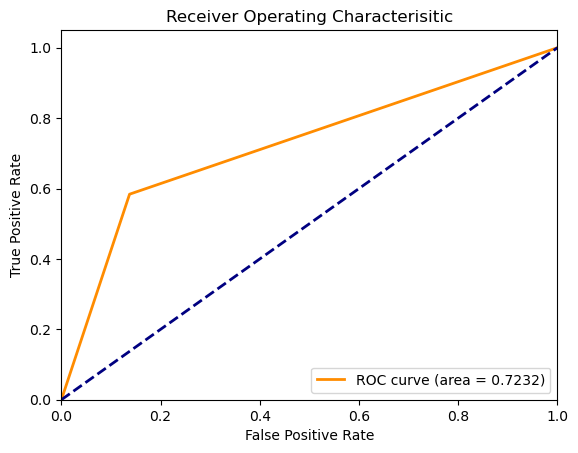

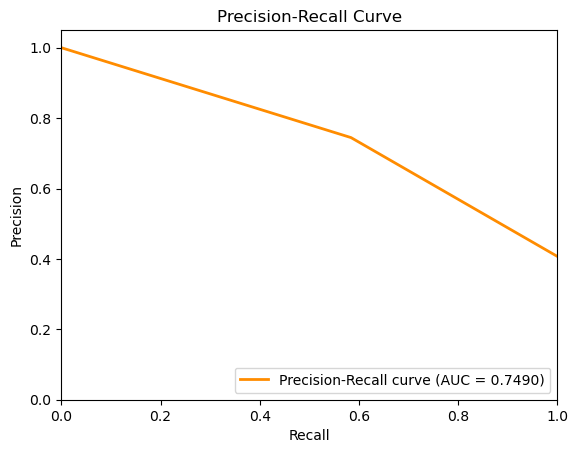

In [19]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# compute ROC curve and ROC area for each clcass
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Compute precision-recall curve and average precision for each class
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Compute the AUC for the precision-recall curve
PrecRec_auc = auc(recall, precision)
print('The AUC for the Precision-Recall Curve is ', round(PrecRec_auc, 5) * 100,
      '%.\n',
      'While the AUC for the AUC for the ROC is ', round(roc_auc, 5) * 100,
      '%.', sep = '')

#plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange', lw = lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characterisitic')
plt.legend(loc = 'lower right')
plt.show()

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color = 'darkorange', lw = lw, label = 'Precision-Recall curve (AUC = %0.4f)' % PrecRec_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc = 'lower right')
plt.show()

# XGBoost Regressor

The second part of this modeling for the VPA is to take the ML prediction of which students who are most likely to *not* reenroll from Fall to Fall (i.e. *specificity*) and assess how the credit hour enrollment would change if different percentages of these students *were* retained. The only way we can really do that is be examining the students who *do* retain and creating a model that predicts how many credit hours those students will enroll in. 

In [ ]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define the parameter grid
param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'gamma': [0, 0.5, 1],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0]
}

# Create XGBRegressor object
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror')

# Set up GridSearchCV
grid = GridSearchCV(estimator = xg_reg, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)

# Fit GridSearchCV to the training data
grid.fit(X_train2, y_train2)

# Print the best parameters
print("Best parameters found: ", grid.best_params_)

# Use the best estimator to make predictions
y_pred = grid.best_estimator_.predict(X_test2)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
print("RMSE: %f" % (rmse))


In [ ]:
from sklearn.metrics import r2_score

# Assume y_test are the true values and y_pred are the predictions from the model
r2 = r2_score(y_test2, y_pred)

# Number of observations
n = len(y_test2)

# Number of predictors. X_train.shape[1] gives the number of features used to train the model.
p = X_train2.shape[1]

# Adjusted R-squared calculation
r2_adj = 1 - (1-r2) * (n-1)/(n-p-1)

print("R-squared: ", r2)
print("Adjusted R-squared: ", r2_adj, '\n')

# Get feature importance
importance = grid.best_estimator_.feature_importances_

# Retrieve feature names
feature_names = X_train2.columns

# Combine feature names and their importance scores
feature_importance_dict = dict(zip(feature_names, importance))

# store feature importance
importance_dict = {}
for feature, score in feature_importance_dict.items():
    importance_dict[feature] = score


In [ ]:
(pd.DataFrame.from_dict(importance_dict, orient = 'index')
   .reset_index()
   .rename(columns = {'index':'variable',
                       0:'importance'})
   .sort_values('importance', ascending = False)
   .reset_index(drop = True)
)

In [ ]:
import matplotlib.pyplot as plt

# Sort the features by importance
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Unzip into two lists
sorted_features, sorted_scores = zip(*sorted_importances)

# Create a bar chart
plt.barh(sorted_features, sorted_scores)
plt.xlabel('Importance')
plt.title('Feature Importances')

# Invert y-axis to have the most important feature on top
plt.gca().invert_yaxis()
plt.show()

### Test Every Classifier

Ok, so this is not *every* classifier, but it is damn close. This is something I came across through Akshay Pachaar. He posted this to Twitter on 11.1.23 and I just had to try it. Lazy Predict ran through all of these models in just a few minutes. With hyperparamter tuning in my XGBoost model, I get an accuracy of 0.7504, which is marginally better than a non-hyperparamter tuned model. LGBM performs the absolute best.

If I want to use regression, you just import *LazyRegressor* and code:

```{python}

reg = LazyRegressor(verbose = 0, ignore_warnings = False, custom_metric = None)

models = reg.fit(X_train, X_test, y_train, y_test)

models

```

This will spit out:

|**Model** | **Adjusted R-Squ**| **R-Squared** | **RMSE** | **Time Taken**|
|:---------|------------------:|--------------:|---------:|--------------:|

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X2 = only_enrolled.drop('term_att_crhr', axis = 1)
y2 = only_enrolled['term_att_crhr'] # response variable

# split the data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2)

# Encode categorical variables
le = LabelEncoder()
for col in X_train2.columns:
    if X_train2[col].dtype == 'object':
        X_train2[col] = le.fit_transform(X_train2[col].astype(str))
        X_test2[col] = le.transform(X_test2[col].astype(str))

In [ ]:
# The "only_enrolled" object is actually below in the "Test Every Classifier" 
# section. So that needs to be run first.
X2 = only_enrolled.drop('term_att_crhr', axis = 1)
y2 = only_enrolled['term_att_crhr'] # response variable

# Encode categorical variables
le = LabelEncoder()
for col in X2.columns:
    if X2[col].dtype == 'object':
        X2[col] = le.fit_transform(X2[col].astype(str))
        
enrolled_pred = grid.best_estimator_.predict(X2)

rmse = np.sqrt(mean_squared_error(y2, enrolled_pred))

print('RMSE: %f' % (rmse))

# Add prediction and original value column
X2['prediction'], X2['term_att_crhr'] = enrolled_pred, y2


In [ ]:
# Change column name in the test set (X2)
X2 = X2.rename(columns = {'term_att_crhr':'original_val'})

# Store as Data Frame
pd.concat([only_enrolled, X2[['prediction', 'original_val']]], axis = 1).to_csv('Enrolled Predictions FA19-FA22.csv', index = False)


# SVM

For some reason, I'm getting some errors in the SVM in R, which never happens. It started after I added the high school and FA data. I decided to just come here and build the model because I wanted to practice making the SVM in python since I usually do most of my model building in R. 

In [ ]:
# Import necessary libraries
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Identify categorical columns that need encoding
categorical_features = ['stype', 'gender', 'ethn_desc', 'resd', 'acd_std_desc', 'fully_online', 'hs_matriculation']

# Create a column transformer to encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

# Create SVM model with a linear kernel (you can choose another kernel like 'rbf' if needed)
svm_model = SVC(kernel='linear', probability = False)

# Make a pipeline that includes preprocessing and the classifier
pipeline = make_pipeline(preprocessor, svm_model)

# Perform ten-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')

print("10-fold cross-validation accuracy scores:", cross_val_scores)
print("Mean CV Accuracy:", np.mean(cross_val_scores))

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, F1-score, and specificity
report = classification_report(y_test, y_pred, target_names=['Not Enrolled', 'Enrolled'])
print(report)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Specificity is just the true negative rate
tp, fp, fn, tn = conf_matrix.ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)


In [ ]:
import matplotlib.pyplot as plt

# plot the scores
plt.figure(figsize = (10, 5))
plt.plot(cross_val_scores, marker = 'o', linestyle = '-', color = 'b')
plt.title('Cross-validation scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(len(cross_val_scores)), [f"Fold {i+1}" for i in range(len(cross_val_scores))])
plt.show()

# create a box plot to show the distribution of scores across the folds
plt.figure(figsize=(10, 5))
plt.boxplot(cross_val_scores, vert = True, patch_artist = True)
plt.title('Cross-validation scores distribution')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
svm_classifier = pipeline.named_steps['svc']

coefficients = svm_classifier.coef_.flatten()

# Get the feature names after one-hot encoding
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([feature_names, X_train.columns.difference(categorical_features)])

# Create a DataFrame with the feature names and their corresponding coefficients
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort the DataFrame based on the absolute values of the importance score
feature_importance = feature_importance.reindex(feature_importance.Importance.abs().sort_values(ascending=False).index)

# Create the lollipop plot - horizontal
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.hlines(y=feature_importance['Feature'], xmin=0, xmax=feature_importance['Importance'], color='dodgerblue')
plt.scatter(feature_importance['Importance'], feature_importance['Feature'], color='darkorange')
plt.xlabel('Importance')
plt.title('Variable Importance of SVM')
plt.grid(False)
plt.gca().invert_yaxis()
plt.show()

# Lazy Predict

I discovered Lazy Predict after I already developed all my other models. Nevertheless, I wanted to try it out to compare its outcomes with my own. 

In [ ]:
# Only enrolled dataframe
only_enrolled = enrolled_gpas_online_fafsa_hs[enrolled_gpas_online_fafsa_hs['enrolled'] == 'Enrolled']

only_enrolled = only_enrolled[['enrolled', 'stype', 'gender', 'ethn_desc', 'resd', 'fully_online',
                  'acd_std_desc', 'age', 'term_att_crhr', 'term_earn_crhr', 'term_gpa',
                  'inst_gpa', 'inst_earned', 'no_pell', 'pell', 'subsidized', 'unsubsidized', 
                  'summer_plus', 'kansas_promise', 'all_fafsa', 'hs_matriculation']].reset_index(drop = True)

only_enrolled['hs_matriculation'] = only_enrolled['hs_matriculation'].fillna('Not From HS')

only_enrolled = only_enrolled[only_enrolled['term_att_crhr'] != only_enrolled['term_att_crhr'].min()]

# Isolate only students who have enrolled
only_enrolled = only_enrolled[only_enrolled['enrolled'] == 'Enrolled'].reset_index(drop = True)

only_enrolled = only_enrolled[['stype', 'gender', 'ethn_desc', 'resd', 'fully_online',
                  'acd_std_desc', 'age', 'term_att_crhr', 'term_earn_crhr', 'term_gpa',
                  'inst_gpa', 'inst_earned', 'no_pell', 'pell', 'subsidized', 'unsubsidized', 
                  'summer_plus', 'kansas_promise', 'all_fafsa', 'hs_matriculation']].reset_index(drop = True)

### Lazy Regressor

The final step of this model deployment was creating a regression model that would predict how much credit hours would increase or decrease if different cohorts of students were retained at higher or lower levels. The Lazy Regressor was a great place to start to see which models I should focus my attention on for tuning.

In [ ]:
from lazypredict.Supervised import LazyRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

reg = LazyRegressor(verbose = 1, ignore_warnings = True, custom_metric = None)
models, predictions = reg.fit(X_train2, X_test2, y_train2, y_test2)

models

In [ ]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(`verbose = 0, ignore_warnings = True, custom_metric = None)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

models